In [1]:
%cd -q ..
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import torchfile
import numpy as np
import imgaug as ia

from random import shuffle, randint
from pathlib import Path
from itertools import chain
from PIL import Image
from imgaug import augmenters as iaa

In [3]:
data_root = Path('/media/SSD2/LS3D-W/300VW-3D/')

In [4]:
data = []

imgs = chain(data_root.glob('**/*.jpg'), 
             data_root.glob('**/*.png'))
for img_path in imgs:
    img_path = img_path.as_posix()
    ann_path = img_path.replace('.jpg', '.t7').replace('.png', '.t7')
    if Path(ann_path).exists():
        data.append((img_path, ann_path))

shuffle(data)
data = [data[i:i+3] for i in range(len(data)//3)]

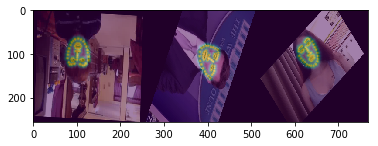

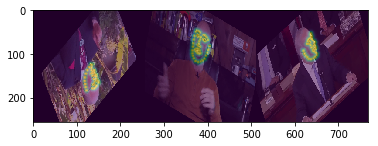

In [5]:
shuffle(data)
for idx, _data in enumerate(data):
    _imgs = []
    _kpts = []
    for img, ann in _data:
        img = np.array(Image.open(img))
        h, w, _ = img.shape
        ann = torchfile.load(ann).astype(np.int32)
        kpt = ia.KeypointsOnImage([ia.Keypoint(x, y) for (x, y) in ann], img.shape)
    
        center = tuple(1 - ann.mean(0) / np.array([w, h]))
        w = ann[:, 0].max() - ann[:, 0].min()
        h = ann[:, 1].max() - ann[:, 1].min()
        s = randint(1, 10)
        aug = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5),
            iaa.Affine(scale=(0.5,1.5)),
            iaa.Affine(rotate=(-60, 60)),
            iaa.Resize((256, 256)),
        ]).to_deterministic()
        img = aug.augment_image(img)
        kpt = aug.augment_keypoints([kpt])[0]
        kpt = kpt.keypoints

        h, w = img.shape[:2]
        hm = np.zeros((68, h, w), dtype=np.float)
        base = np.indices((h, w), dtype=np.float)
        kpt_base = np.tile(base, (68, 1, 1))
        kpt_arrays = []
        for i in range(68):
            kpt_arr = np.zeros_like(base)
            kpt_arr[0, :] = kpt[i].y #// 2
            kpt_arr[1, :] = kpt[i].x #// 2
            kpt_arrays.append(kpt_arr)
        
        kpt_arrays = np.concatenate(kpt_arrays, axis=0)
        kpt_arrays = (kpt_arrays - kpt_base) ** 2

        for i in range(68):
            dst = np.exp(-np.sum(kpt_arrays[2*i:2*(i + 1)], axis=0) / (2 * (4 ** 2)))
            hm[i] = np.maximum(hm[i], dst)

        _imgs.append(img)
        _kpts.append(hm)
        
    _imgs = np.hstack(_imgs)
    _kpts = np.concatenate(_kpts, 2)
    
    plt.figure()
    plt.imshow(_imgs)
    plt.imshow(_kpts.max(0), alpha=0.5)
    
    if idx == 1: break 

In [6]:
kpt

[Keypoint(x=107.62106476, y=92.60534459),
 Keypoint(x=110.00703489, y=99.15147862),
 Keypoint(x=112.93127547, y=103.53193289),
 Keypoint(x=116.40897769, y=107.40013870),
 Keypoint(x=119.60614106, y=111.11111121),
 Keypoint(x=125.00958530, y=111.94635880),
 Keypoint(x=130.57470414, y=110.13072363),
 Keypoint(x=134.64110280, y=107.20091739),
 Keypoint(x=137.95432342, y=103.30070479),
 Keypoint(x=138.47737397, y=99.48158969),
 Keypoint(x=136.12942819, y=97.06902773),
 Keypoint(x=133.31645225, y=94.66998368),
 Keypoint(x=129.27767513, y=90.48732090),
 Keypoint(x=126.16134084, y=85.45090240),
 Keypoint(x=123.78298396, y=79.73147380),
 Keypoint(x=121.58910754, y=73.84130400),
 Keypoint(x=118.84175724, y=68.46338786),
 Keypoint(x=116.31212055, y=76.64090275),
 Keypoint(x=117.93451785, y=70.97056968),
 Keypoint(x=119.76421371, y=67.60963175),
 Keypoint(x=120.76750066, y=65.43043446),
 Keypoint(x=122.05893972, y=64.23517590),
 Keypoint(x=124.69982882, y=58.03907644),
 Keypoint(x=125.14203947, y